In [ ]:
pip install q keras==1.2.2


     |████████████████████████████████| 184kB 6.0MB/s 
  Created wheel for keras: filename=Keras-1.2.2-cp37-none-any.whl size=209602 sha256=d56993dda0abc6d9bb1f628ef938de65de5000e94e4598f4fa9faf920a095ce7
  Stored in directory: /root/.cache/pip/wheels/55/07/cf/b32db0a8d243b2fd6759d5d7cb650aa20670b2b740209cbf7e
Successfully built keras
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 1.2.2 which is incompatible.
ERROR: kapre 0.1.3.1 has requirement keras>=2.0.0, but you'll have keras 1.2.2 which is incompatible.
ERROR: fancyimpute 0.4.3 has requirement keras>=2.0.0, but you'll have keras 1.2.2 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
pip install tensorflow==1.13.1

     |████████████████████████████████| 92.6MB 76kB/s 
     |████████████████████████████████| 368kB 48.4MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 3.2MB 38.3MB/s 
ERROR: fancyimpute 0.4.3 has requirement keras>=2.0.0, but you'll have keras 1.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [ ]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense,Merge, RepeatVector, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [ ]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

In [ ]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [ ]:
unique = pickle.load(open('/content/drive/My Drive/ML/unique.p', 'rb'))

In [ ]:
word2idx = {val:index for index, val in enumerate(unique)}

In [ ]:
idx2word = {index:val for index, val in enumerate(unique)}

In [ ]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('/content/drive/My Drive/ML/flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])
       


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [ ]:
embedding_size = 300
max_len = 40
vocab_size = 8256

In [ ]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [ ]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [ ]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [ ]:
# final_model.load_weights('/content/drive/My Drive/ML/sample_model.h5')

In [ ]:
final_model.load_weights('/content/drive/My Drive/ML/time_inceptionV3_3.21_loss.h5')

In [ ]:
def predict_caption(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encode(image)
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:
def beam_search_prediction(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encode(image)
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
# pic1 = '/content/drive/My Drive/ML2/pic1.jpg'
# pic2 = '/content/drive/My Drive/ML2/pic2.jpg'
# pic3 = '/content/drive/My Drive/ML2/pic3.jpg'
# pic4 = '/content/drive/My Drive/ML2/pic4.jpg'

pic1 = '/content/drive/My Drive/ML/Flicker8k_Dataset/109202801_c6381eef15.jpg'
pic2 = '/content/drive/My Drive/ML/Flicker8k_Dataset/3765374230_cb1bbee0cb.jpg'
pic3 = '/content/drive/My Drive/ML/bc.jpg'
pic4 = '/content/drive/My Drive/ML/second2.jpg'

In [ ]:
token = '/content/drive/My Drive/ML/Flickr8k.token.txt'
captions = open(token, 'r').read().strip().split('\n')
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [ ]:
def split_data(l):
    temp = []
    for i in img:
        if i in l:
            temp.append(i)
    return temp

In [ ]:
images = '/content/drive/My Drive/ML/Flicker8k_Dataset'

In [ ]:
# Contains all the images
import os
img = [fil for fil in os.listdir(images) if fil.endswith(".jpg")]
len(img)

8091

In [ ]:
test_images_file = '/content/drive/My Drive/ML/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_img = split_data(test_images)

In [ ]:
actual, predicted = list(), list()
c = 0
for pic in test_img:
  c = c+1
  print(c)
  yhat = predict_caption('/content/drive/My Drive/ML/Flicker8k_Dataset/' + pic)
  references = [x.split() for x in d[pic]]
  actual.append(references)
  predicted.append(yhat.split())

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.506245
BLEU-2: 0.289857
BLEU-3: 0.202369
BLEU-4: 0.101237


In [ ]:
print('BLEU: %f' % corpus_bleu(actual, predicted))

Two horses are pulling a woman in a cart .


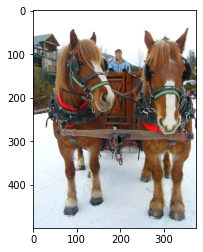

A child in a swimsuit walks among large waves .


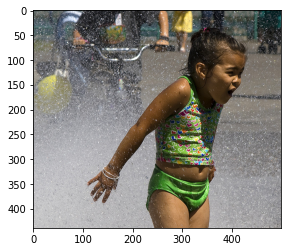

A man is riding a bicycle on the beach .


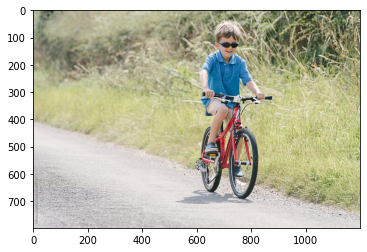

A dog is jumping in the air to catch an item .


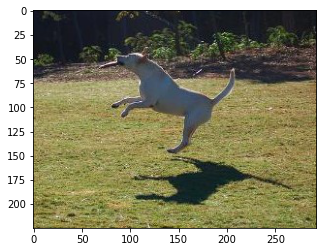

In [ ]:
# print(beam_search_prediction(pic1,5))
print(predict_caption(pic1))
x1=plt.imread(pic1)
plt.imshow(x1)
plt.show()

# print(beam_search_prediction(pic2,5))
print(predict_caption(pic2))
x2=plt.imread(pic2)
plt.imshow(x2)
plt.show()

# print(beam_search_prediction(pic3,5))
print(predict_caption(pic3))
x3=plt.imread(pic3)
plt.imshow(x3)
plt.show()

# print(beam_search_prediction(pic4,5))
print(predict_caption(pic4))
x4=plt.imread(pic4)
plt.imshow(x4)
plt.show()

In [ ]:
pic10 = '/content/drive/My Drive/ML/test/bike1.png'
pic20 = '/content/drive/My Drive/ML/test/last1.jpg'
pic30 = '/content/drive/My Drive/ML/test/sixth.png'
pic40 = '/content/drive/My Drive/ML/test/c5.png'

In [ ]:
print(beam_search_prediction(pic10,5))
print(predict_caption(pic10))
x1=plt.imread(pic10)
plt.imshow(x1)
plt.show()

print(beam_search_prediction(pic20,5))
print(predict_caption(pic20))
x2=plt.imread(pic20)
plt.imshow(x2)
plt.show()

print(beam_search_prediction(pic30,5))
print(predict_caption(pic30))
x3=plt.imread(pic30)
plt.imshow(x3)
plt.show()

print(beam_search_prediction(pic40,5))
print(predict_caption(pic40))
x4=plt.imread(pic40)
plt.imshow(x4)
plt.show()